In [1]:
import networkx as nx
import numpy as np
import random
import shutil
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
class RandomWeightedGraph(nx.Graph):
    def __init__(self, nodes: int):
        super().__init__(nx.bipartite.random_graph(nodes, nodes, 0.5).edges())
        for (u, v) in self.edges():
            self.edges[u, v]['weight'] = np.random.randint(10, 100)

    def weight(self, edge):
        return self.edges[edge]['weight']

In [3]:
class MinimumSpanningTree(dict):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        self._original_G, self._G, self._root = G.copy(), G, root
        self.counter = 0
        files = glob.glob('../images/dijkstra/*')
        for f in files:
            os.remove(f)
        if describe:
            self._setup_describe()

    def _setup_describe(self):
        self._pos = nx.spring_layout(self._G, iterations=10000)
        gray, self._dark_gray = '#eeeeee', '#555555'
        self._node_colors = [gray for n in self._G]
        self._edge_colors = [gray for e in self._G.edges]
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _plot_graphs(self, graphs: list, title: str):
        n, graph_size, graph_per_row = len(graphs), 3, 4
        w, h = min(n, graph_per_row), np.ceil(n / graph_per_row)
        plt.figure(figsize=(graph_size * w, graph_size * h))
        plt.suptitle(title)
        for i, (G, colors, title) in enumerate(graphs):
            ax = plt.subplot(h, w, i + 1)
            ax.set_xlim(self._min_x, self._max_x)
            ax.set_ylim(self._min_y, self._max_y)
            ax.set_title(title)
            nx.draw(
                self._original_G,
                pos=self._pos,
                with_labels=True,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
                node_color=self._node_colors,
                edge_color=self._edge_colors)
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=colors,
                edge_color=colors)
            nx.draw_networkx_edge_labels(
                self._original_G,
                pos=self._pos,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        legend = {
            "Tree": "r",
            "Unexplored": "c",
            "Current node": "m",
            "Unexplored neighbours": "g"
        }

        plt.savefig("../images/dijkstra/{c}.png".format(c=self.counter))
        self.counter+=1
        plt.show()

    def _describe_start(self, root: int):
        tree = nx.Graph()
        tree.add_node(root)
        colors = ['r' for n in self._original_G]
        self._plot_graphs([(self._original_G, colors, "Initial Graph"),
                           (tree, colors, "Initial Tree")],
                          "Initial Conditions")

In [4]:
class Dijkstra(MinimumSpanningTree):
    def __init__(self,
                 G: nx.Graph,
                 start: int,
                 end: int,
                 describe: bool = False):
        super().__init__(G, start, describe=describe)
        self._costs = dict((v, np.inf) if v != start else (v, 0) for v in G)

    def run(self):
        self._tree = {}
        self._pred = {start: start}
        while self._costs:
            self.iteration()
        current_node = end
        while current_node != start:
            new_node = self._tree[current_node]
            self[current_node] = new_node
            current_node = new_node

    def iteration(self):
        self._node = min(self._costs, key=self._costs.get)
        self._tree[self._node] = self._pred[self._node]
        self._neighbors = []
        for v in self._G.neighbors(self._node):
            if v in self._costs and self._G.weight(
                (self._node, v)) + self._costs[self._node] < self._costs[v]:
                self._pred[v] = self._node
                self._neighbors.append(v)
                self._costs[v] = self._G.weight(
                    (self._node, v)) + self._costs[self._node]
        self._costs.pop(self._node, None)

    def _is_spanning(self):
        return len({v for g in zip(*self.items()) for v in g}) == len(self._G)

In [5]:
class GraphicalDijkstra(Dijkstra):
    def __init__(self, G: nx.Graph, start: int, end: int):
        super().__init__(G, start, end, True)

    def run(self):
        self._i = 0
        super().run()
        self._plot_graphs(
            [(nx.Graph(list(self.items())), 'C7', "")],
            "Completed Algorithm")

    def iteration(self):
        super().iteration()
        self._plot_graphs(
            [(*self._create_iteration_graph(self._costs, self._neighbors,
                                            self._node), "Current step"),
             (nx.Graph(list(self._tree.items())), 'r', "Current Tree")],
            "Iteration {i}".format(i=self._i))
        self._i += 1

    def _create_iteration_graph(self, costs: dict, neighbors: list,
                                node: int) -> tuple:
        iteration = nx.Graph()
        [iteration.add_node(v) for v in [*costs, node, *neighbors]]
        colors = [
            'g' if v in neighbors else 'm' if v == node else 'c'
            for v in iteration
        ]
        return iteration, colors

In [6]:
seed = 66
random.seed(seed)
np.random.seed(seed)
G = RandomWeightedGraph(4)
start = 4
end = 3

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


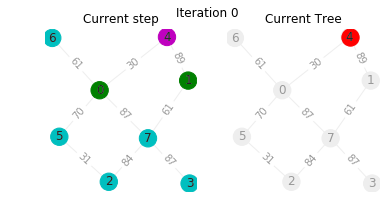

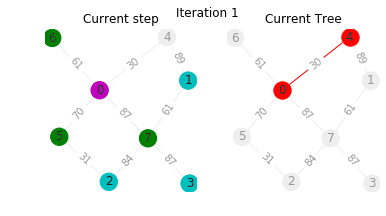

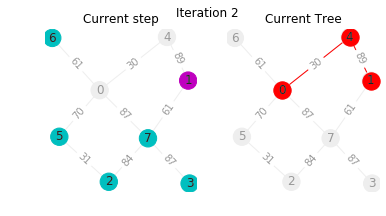

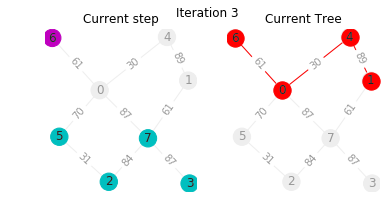

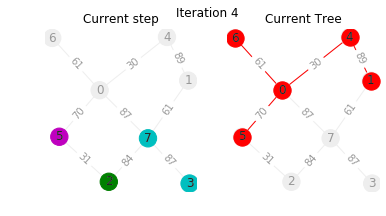

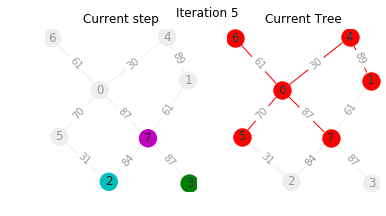

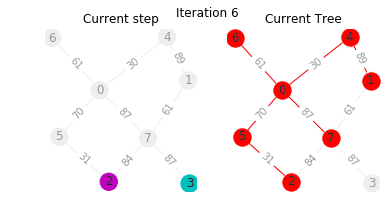

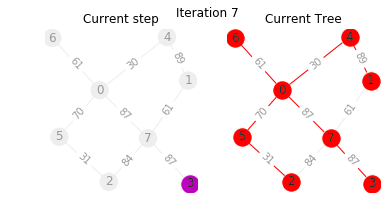

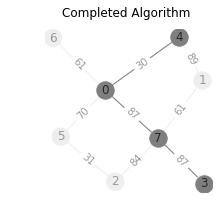

In [7]:
GraphicalDijkstra(G, start, end).run()